<a href="https://colab.research.google.com/github/gvtsch/Udemy_TensorFlow_Certificate/blob/main/10_time_series_forecasting_with_TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time series forecasting fundamental with TensorFlow + Milestone Project 3: BitPredict 💰

Let's write some TensorFlow code to predict the price of Bitcoin based on the historical price of Bitcoin.

⚠ **Note:** This is not financial advice.

Links:
* All resources: https://github.com/mrdbourke/tensorflow-deep-learning
* Book version of actual code/text: https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/10_time_series_forecasting_in_tensorflow.ipynb

## Get data

We're going to be using the historica price data of Bitcoin to try and predict the future price of Bitcoin.

To follow along the video with using the same data i am using the data from course's github repository. If i wanted to use other data i could download it e.g. [
  here](https://query1.finance.yahoo.com/v7/finance/download/BTC-USD?period1=1410912000&period2=1656460800&interval=1d&events=history&includeAdjustedClose=true)

In [1]:
import os
if not os.path.exists("BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv"):
  # !python -m wget !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
  !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv


--2022-06-30 06:49:13--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.03s   

2022-06-30 06:49:14 (5.88 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’ saved [178509/178509]



## Importing time series with pandas

In [2]:
# Import with pandas
import pandas as pd

# Let's read in our Bitcoin data and parse the dates
df = pd.read_csv("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv",
                 parse_dates=["Date"],
                 index_col=["Date"]) # parse the date column and tell pandas column 1 is a datetime

df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [3]:
df.tail()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2021-05-14,BTC,49764.132082,49596.778891,51448.798576,46294.720180
2021-05-15,BTC,50032.693137,49717.354353,51578.312545,48944.346536
2021-05-16,BTC,47885.625255,49926.035067,50690.802950,47005.102292
2021-05-17,BTC,45604.615754,46805.537852,49670.414174,43868.638969
2021-05-18,BTC,43144.471291,46439.336570,46622.853437,42102.346430


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


In [5]:
# How many samples do we have?
len(df)

2787

We've collected the historical price of bitcoin for the past ~8 years but there's 2787 samples.

Typically deep learning models usually like lots and lots and lots of samples (where lots and lots and lots can be thousands to tens of thousands to millions).

A smaller number of samples is something you'll often run into with time series data problems.


> 🔑 **Note:** The **seasonality** of a time series dataset is referred as the number of samples per year. So for our Bitcoin data, it has a seasonality of daily or value of 365 because we collect one sample per day meaning we'll get 365 samples per year.

In [6]:
# We only want closing price for each day
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "Price"})
bitcoin_prices

,Price
Date,
2013-10-01,123.654990
2013-10-02,125.455000
2013-10-03,108.584830
2013-10-04,118.674660
2013-10-05,121.338660
...,...
2021-05-14,49764.132082
2021-05-15,50032.693137
2021-05-16,47885.625255


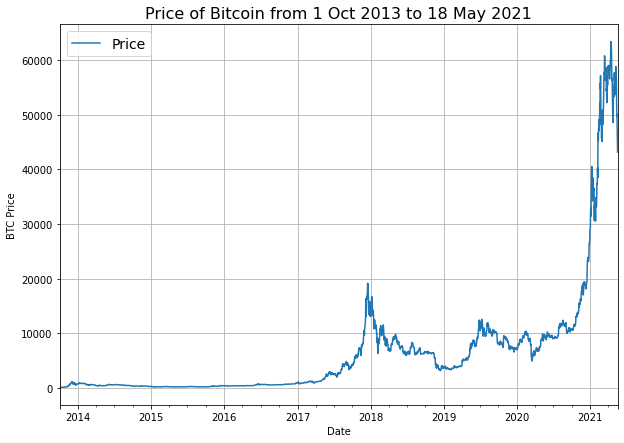

In [7]:
import matplotlib.pyplot as plt
bitcoin_prices.plot(figsize=(10, 7))
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021", fontsize=16)
plt.legend(fontsize=14)
plt.grid()

## Importing time series data with Python's CSV module

In [8]:
# Importing and formatting historical Bitcoin data with Python
import csv
from datetime import datetime

timesteps = []
btc_price = []
with open("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", "r") as f:
  csv_reader = csv.reader(f, delimiter=",")
  next(csv_reader) # skip first line (this gets rid of the column titles)
  for line in csv_reader:
    timesteps.append(datetime.strptime(line[1], "%Y-%m-%d")) # get the dates as dates not strings
    btc_price.append(float(line[2])) # get the closing price as float

In [9]:
# View first 10 of each
timesteps[:10], btc_price[:10]

([datetime.datetime(2013, 10, 1, 0, 0),
  datetime.datetime(2013, 10, 2, 0, 0),
  datetime.datetime(2013, 10, 3, 0, 0),
  datetime.datetime(2013, 10, 4, 0, 0),
  datetime.datetime(2013, 10, 5, 0, 0),
  datetime.datetime(2013, 10, 6, 0, 0),
  datetime.datetime(2013, 10, 7, 0, 0),
  datetime.datetime(2013, 10, 8, 0, 0),
  datetime.datetime(2013, 10, 9, 0, 0),
  datetime.datetime(2013, 10, 10, 0, 0)],
 [123.65499,
  125.455,
  108.58483,
  118.67466,
  121.33866,
  120.65533,
  121.795,
  123.033,
  124.049,
  125.96116])

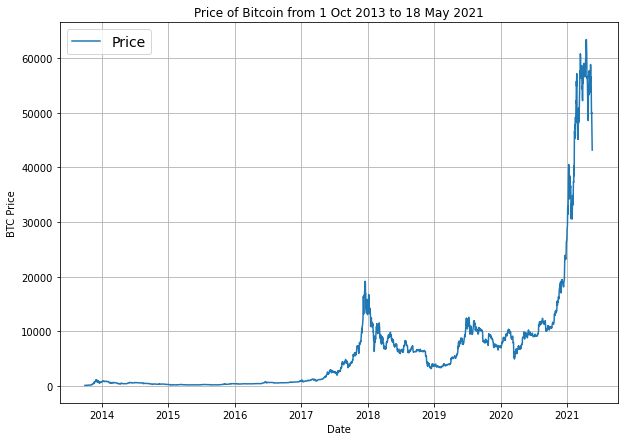

In [10]:
# Plot from csv
plt.figure(figsize=(10, 7))
plt.plot(timesteps, btc_price)
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021")
plt.ylabel("BTC Price")
plt.xlabel("Date")
plt.legend(["Price"], fontsize=14)
plt.grid()

## Format data part 1: Create train and test sets of our time series data

### Creating train and test sets with time series data (the wrong way)

In [11]:
bitcoin_prices[:5]

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [12]:
# Get bitcoin date array
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["Price"].to_numpy()
timesteps[:5], prices[:5]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000'], dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866]))

In [13]:
# Wrong way to make train/test sets for time series data
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(timesteps, 
                                                    prices, 
                                                    test_size=0.2,
                                                    random_state=42)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((2229,), (558,), (2229,), (558,))

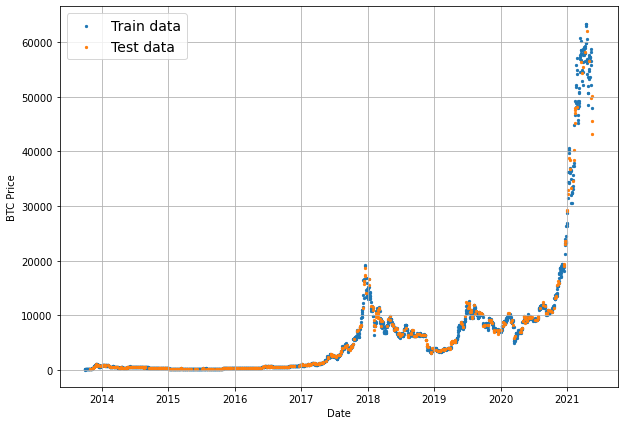

In [14]:
# Let's plot wrong train and test splits
plt.figure(figsize=(10, 7))
plt.scatter(x_train, y_train, s=5, label="Train data")
plt.scatter(x_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.grid()
plt.show()

### Create train and test sets for time series (the right way)

In [15]:
# Create train and test splits the right way for time series data
split_size = int(0.8 * len(prices)) # 80% train, 20% test

# Create train data splots (everything before the split)
x_train, y_train = timesteps[:split_size], prices[:split_size]

# Create test data splits (everything beyond the split)
x_test, y_test = timesteps[split_size:], prices[split_size:]

len(x_train), len(x_test), len(y_train), len(y_test)

(2229, 558, 2229, 558)

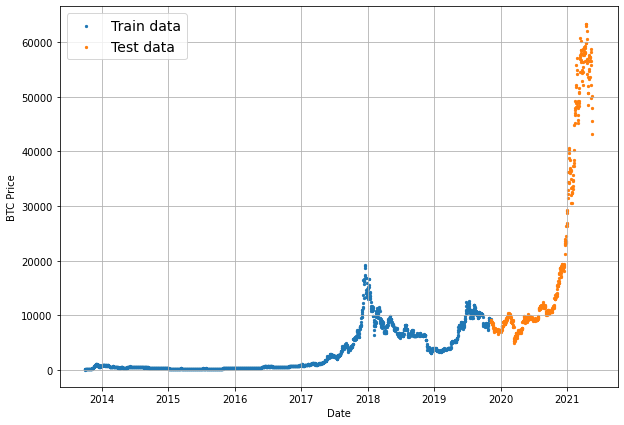

In [16]:
# Plot correctly made splits
plt.figure(figsize=(10, 7))
plt.scatter(x_train, y_train, s=5, label="Train data")
plt.scatter(x_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.grid()
plt.show()

## Create a plotting function

Typing plotting code is tedious, let's functionize it.

In [17]:
# Create a function to plot time series data
def plot_time_series(timesteps, values, format=".", start=0, end=None, label=None):
  """
  Plots timesteps (a series of points in time) against values (a series of values across timesteps).
  
  Parameters
  ---
  timesteps : array of timestep values
  values : array of values across time
  format : style of plot, default "."
  start : where to start the plot (setting a value will indes from start of timesteps and values)
  end : where to end the plot (similoar to start but for the end)
  label : label to show on plot about values
  """

  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label: 
    plt.legend(fontsize=14) 
  plt.grid(True)


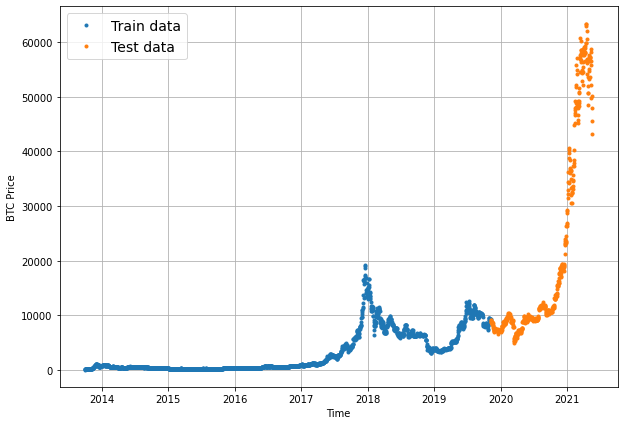

In [18]:
# Test out plotting function
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=x_train, values=y_train, label="Train data")
plot_time_series(timesteps=x_test, values=y_test, label="Test data")

## Modelling Experiments

We've got some Bitcoin historical data, to model it, let's run a series of modelling experiments and see which model performs best.

Terms to be familiar with:
* **Horizon** = number of timesteps into the future we're going to predict
* **Window** = number of timesteps we're going to use to predict horizon

Modelling experiments we're running:
0. Naïve model (baseline)
1. Dense model, horizon = 1, window = 7
2. Same as 1, horizon = 1, window = 30
3. Same as 1, horizon = 7, window = 30
4. Conv1D, horizon = 1, window = 7
5. LSTM, horizon = 1, window = 7
6. Same as 1 (but with mulitvariate data), horizon = 1, window = 7
7. N-BEATs Algorithm, horizon = 1, window = 7
8. Ensemble (multiple models optimized on different loss functions), horizon = 1, window = 7
9. Future prediction model (model to predict future values), horizon = 1, window = 7
10. Same as 1 (but with turkey 🦃 data introduced), horizon = 1, window = 7

## Model 0: Naïve Forecast (baseline)

The formula looks like this:

$$\hat{y}_{t} = y_{t-1}$$

In English:
> The prediction at timestep t (y-hat) is equal to the value at timestep t-1 (previous timestep) - this is for a horizon of 1.

In [19]:
y_test[:10], y_test[-10:]

(array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 ]),
 array([58788.20967893, 58102.19142623, 55715.54665129, 56573.5554719 ,
        52147.82118698, 49764.1320816 , 50032.69313676, 47885.62525472,
        45604.61575361, 43144.47129086]))

In [20]:
# Create a Naive forecast
naive_forecast = y_test[:-1]

naive_forecast[:10], naive_forecast[-10:]

(array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 ]),
 array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
        56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
        47885.62525472, 45604.61575361]))

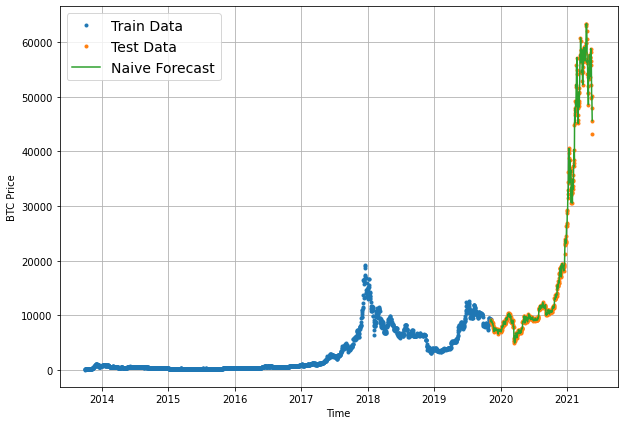

In [21]:
# Plot naive dorecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=x_train, values=y_train, label="Train Data")
plot_time_series(timesteps=x_test, values=y_test, label="Test Data")
plot_time_series(timesteps=x_test[1:], values=naive_forecast, format="-", label="Naive Forecast")

## Evaluating a time series model

Let's look into some evaluation metrics for time series forecasting predictions.

What are we doing? 

We're predicting a number, so that means we have a form of a regression problem.

Because we're working on a regression problem, we'll need some regression-like metrics. 

A few common regression metrics (which can also be used for time series forecasting):
* MAE - Mean Absolute Error
* MSE - Mean Squared Error
* RMSE - Root Mean Squared Error
* MAPE = (Symmetric) Mean Absolute Percentage Error
* MASE - Mean Absolute scaled error

For all the aboive metrics, **lower is better**, for example, an MAE of 0 that is better than an MAE of 100.

The main thing we're evaluating here is: **How do our model's forecasts (y_pred) compare against the actual values (y_true or ground truth values)?**

In [22]:
import tensorflow as tf

In [37]:
# MASE implementation
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality of data).
  """

  mae = tf.reduce_mean(tf.abs(y_true-y_pred))

  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:]-y_true[:-1])) # our seasonality is 1 day (hence the shift of 1)

  return mae / mae_naive_no_season

In [38]:
# Test MASE (this value should = 1 or be very close to 1 with the naive forecast)
mean_absolute_scaled_error(y_true=y_test[1:], y_pred=naive_forecast).numpy()

0.9995699939182624

In [39]:
# Create a function to take in model predictions and truth values and return evaluation metrics
def evaluate_preds(y_true, y_pred):
  # Make sure float32 datatype (for metrics calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various evaluation metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  return {
      "mae": mae.numpy(), 
      "mse": mse.numpy(),
      "rmse": rmse.numpy(),
      "mape": mape.numpy(),
      "mase": mase.numpy()
  }

That's one good looking evaluation function!

Let's now see if it works...

In [40]:
naive_results = evaluate_preds(
    y_true=y_test[1:], 
    y_pred=naive_forecast
)
naive_results

{'mae': 567.9802,
 'mape': 2.5165248,
 'mase': 0.99957,
 'mse': 1147547.0,
 'rmse': 1071.2362}

In [43]:
naive_forecast[-10:]

array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
       56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
       47885.62525472, 45604.61575361])

In [44]:
tf.reduce_mean(y_test)

<tf.Tensor: shape=(), dtype=float64, numpy=20056.632963737226>

In [47]:
tf.reduce_min(y_test), tf.reduce_max(y_test)

(<tf.Tensor: shape=(), dtype=float64, numpy=4944.7023359837>,
 <tf.Tensor: shape=(), dtype=float64, numpy=63346.7890351052>)

## Other models you can use for baselines and for actual forecasts

In this notebook we're  focused on TensorFlow and deep learning models.

However there are plenty of other styles of time series forecasting models you may want to experiment with.

* [Moving average](https://machinelearningmastery.com/moving-average-smoothing-for-time-series-forecasting-python/)
* [ARIMA (Autoregression Integrated Moving Average)](https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/)
* [sktime (Scikit-Learn for time series)](https://github.com/alan-turing-institute/sktime)
* [TensorFlow Decision Forests (random forest, gradient boosting trees)](https://www.tensorflow.org/decision_forests)
* [Facebook Kats (purpose-built forecasting and time series analysis library by Facebook)](https://github.com/facebookresearch/Kats)
* [LinkedIn Greykite (flexible, intuitive and fast forecasts)](https://github.com/linkedin/greykite)

## Format Data Part 2: Windowing our dataset

Why do we window?

We window our time series dataset to turn our data into a supervised learning problem.

```
Windowing for one week
[0, 1, 2, 3, 4, 5, 6] -> [7]
[1, 2, 3, 4, 5, 6, 7] -> [8]
[2, 3, 4, 5, 6, 7, 8] -> [9]
```

In [66]:
import numpy as np

In [58]:
btc_price[:10]

[123.65499,
 125.455,
 108.58483,
 118.67466,
 121.33866,
 120.65533,
 121.795,
 123.033,
 124.049,
 125.96116]

In [55]:
# What we want to do with our Bitcoin data
print(f"We want to use {btc_price[:7]} to predict {btc_price[7]}")

We want to use [123.65499, 125.455, 108.58483, 118.67466, 121.33866, 120.65533, 121.795] to predict 123.033


In [56]:
# Let's setup global variable for window and horizon size
HORIZON = 1
WINDOW_SIZE = 7

In [64]:
# Create function to label windowed data
def get_labelled_windows(x, horizon=HORIZON):
  """
  Creates labels for windowed dataset.

  E.g. if horizon=1
  Input: [0, 1, 2, 3, 4, 5, 6, 7] -> ([0, 1, 2, 3, 4, 5, 6], [7])
  """
  return x[:, :-horizon], x[:, -horizon:]

In [65]:
# Test out the window labelling function
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8), axis=0))
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label {tf.squeeze(test_label.numpy())}")

Window: [0 1 2 3 4 5 6] -> Label 7


We've got a way to label our windowed data.

Howevee, this only works on a small scale.

We need a way tot do the above across our entire time series.

We could do this with python for loops, however, for large time series, that'd be quite slow.

To speed things up, we'll leverage NumPy's array indexing - https://numpy.org/doc/stable/reference/arrays.indexing.html

Our function will:
1. Create a window step of specific window size (e.g. [0, 1, 2, 3, 4, 5, 6])
2. Use NumPy indexing to create a 2D array of multiple window steps, for example 
```
[[0, 1, 2, 3, 4, 5, 6],
[1, 2, 3, 4, 5, 6, 7],
[2, 3, 4, 5, 6, 7, 8]]
```
3. Uses the 2D array of multiple window steps (from 2.) to index on a target series (e.g. the historical price of Bitcoin)
4. Uses our `get_labelled_window()` function we created above to turn the window steps into windows with a specified horizon.

> 📖 **Resource:** The function we're about to create has been adapted from the following article: https://towardsdatascience.com/fast-and-robust-sliding-window-vectorization-with-numpy-3ad950ed62f5

In [78]:
# Create function to view NumPy array as windows
def make_windows(x, window_size=WINDOW_SIZE, horizon=HORIZON):
  """
  Turns a 1D array into a 2D array of sequential labelled windows of window_size with horizon size labels.
  """
  # 1. Create a window of specific window_size (add the hoizon on the end for labelling later)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)

  # 2. Create a 2D array of multiple window steps (minus -1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T 
    # create 2D array of windows of size window_size
  # print(f"Window indexes: \n{window_indexes, window_indexes.shape}")

  # 3. Index on the target array (a time series) with 2D Array of multiple window steps
  windowed_array = x[window_indexes]
  # print(windowed_array)

  # 4. Get the labeled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)
  return windows, labels

In [80]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE)
len(full_windows), len(full_labels), len(prices)

(2780, 2780, 2787)

In [81]:
# View the first windows/labels
for i in range(3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] -> Label: [123.033]
Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] -> Label: [124.049]
Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] -> Label: [125.96116]


In [82]:
# View the last 3
for i in range(3):
  print(f"Window: {full_windows[i-3]}, Label: {full_labels[i-3]}")

Window: [58788.20967893 58102.19142623 55715.54665129 56573.5554719
 52147.82118698 49764.1320816  50032.69313676], Label: [47885.62525472]
Window: [58102.19142623 55715.54665129 56573.5554719  52147.82118698
 49764.1320816  50032.69313676 47885.62525472], Label: [45604.61575361]
Window: [55715.54665129 56573.5554719  52147.82118698 49764.1320816
 50032.69313676 47885.62525472 45604.61575361], Label: [43144.47129086]


In [83]:
prices[-1]

43144.4712908603

> 🔑 **Note:** You can find a function which achieces similar results to the ones we implemented above at [tf.keras.preprocessing.timeseries_dataset_from_array()](https://keras.io/api/preprocessing/timeseries/). Just like ours, it takes in an array and returns a windowed dataset. It has the benefit of returning data in the form of a tf.data.Dataset instance (we'll see how to do this with our own data later).